In [ ]:
# Import all necessary libraries for the task

import re
import string
import torch
import numpy as np
import pandas as pd
import nltk
import emoji

import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

import transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModel
from transformers import Trainer, TrainingArguments
from transformers import AdamW
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from nltk.corpus import stopwords
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split

from transformers import BertTokenizerFast
from transformers import TFBertModel, TFAutoModelForSequenceClassification
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

#########################################################

In [37]:
df_train = pd.read_csv('/kaggle/input/input-data/HODI_2023_train_subtaskA.tsv', sep='\t')
df_test = pd.read_csv('/kaggle/input/input-data/HODI_2023_test_subtaskA.csv', sep='\t')

In [52]:
df_test.info()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1000 non-null   int64 
 1   text    1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               5000 non-null   int64 
 1   text             5000 non-null   object
 2   homotransphobic  5000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 117.3+ KB


In [ ]:
# df_train = df_train[["text", "homotransphobic"]]

In [ ]:
# df_test = df_test[["text"]]

In [39]:
#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

In [40]:
texts_new = []
for t in df_train.text:
    texts_new.append(clean_hashtags(strip_all_entities(t)))

In [41]:
texts_new_test = []
for t in df_test.text:
    texts_new_test.append(clean_hashtags(strip_all_entities(t)))

In [42]:
df_train["text"] = texts_new
df_test["text"] = texts_new_test

In [43]:
X = df_train["text"].values
y = df_train["homotransphobic"].values

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=48)

In [45]:
X_test = df_test['text'].values

In [46]:
MAX_LEN = 161

In [47]:
# Tokenization of data

def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [48]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [49]:
def create_model(bert_model, max_len=MAX_LEN):

    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    outputs = bert_model([input_ids, attention_masks])

    # Extract the logits from TFSequenceClassifierOutput
    logits = outputs.logits

    # Modify the pooling 
    pooled = tf.reduce_mean(logits, axis=1)
    
    # Reshape the pooled tensor to (None, 1)
    pooled = tf.keras.layers.Reshape((1,))(pooled)

    output = tf.keras.layers.Dense(1, activation="sigmoid")(pooled)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])

    return model

In [50]:
# Load the BERT model from HuggingFace
MODEL = f"Musixmatch/umberto-wikipedia-uncased-v1"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2, from_pt=True)

All PyTorch model weights were used when initializing TFCamembertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFCamembertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
model = create_model(model, MAX_LEN)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 161)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 161)]                0         []                            
                                                                                                  
 tf_camembert_for_sequence_  TFSequenceClassifierOutput   1106234   ['input_3[0][0]',             
 classification_1 (TFCamemb  (loss=None, logits=(None,    90         'input_4[0][0]']             
 ertForSequenceClassificati  2),                                                                  
 on)                          hidden_states=None, atten                                     

In [53]:
history_bert = model.fit([train_input_ids,train_attention_masks], 
                         y_train, 
                         validation_data=([val_input_ids,val_attention_masks], 
                                          y_valid), 
                         epochs=4, batch_size=32)

Epoch 1/4
141/141 [==============================] - 194s 1s/step - loss: 0.6420 - binary_accuracy: 0.6256 - val_loss: 0.5738 - val_binary_accuracy: 0.7060
Epoch 2/4
141/141 [==============================] - 142s 1s/step - loss: 0.5116 - binary_accuracy: 0.7573 - val_loss: 0.4901 - val_binary_accuracy: 0.7800
Epoch 3/4
141/141 [==============================] - 142s 1s/step - loss: 0.4179 - binary_accuracy: 0.8218 - val_loss: 0.4390 - val_binary_accuracy: 0.8080
Epoch 4/4
141/141 [==============================] - 142s 1s/step - loss: 0.3464 - binary_accuracy: 0.8604 - val_loss: 0.4624 - val_binary_accuracy: 0.8160


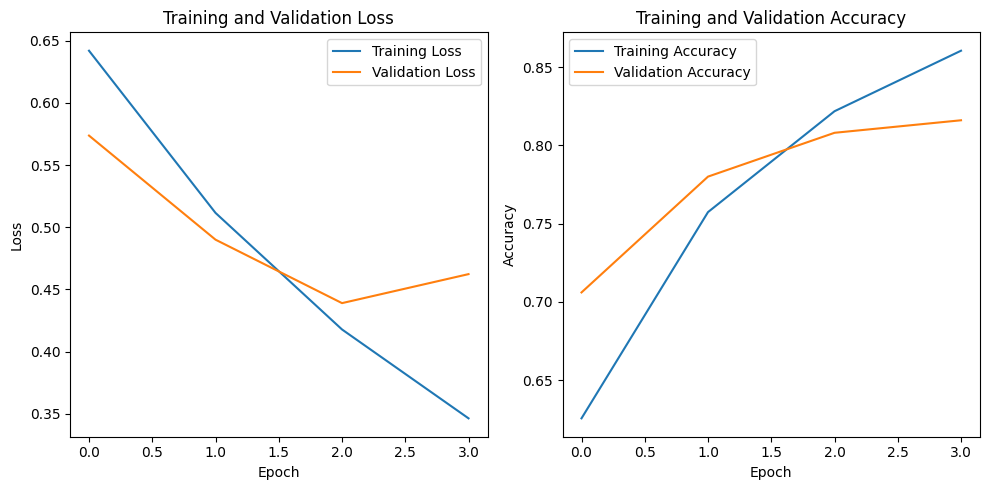

In [54]:
train_loss = history_bert.history['loss']
val_loss = history_bert.history['val_loss']
train_accuracy = history_bert.history['binary_accuracy']  # Adjust metric name if needed
val_accuracy = history_bert.history['val_binary_accuracy']  # Adjust metric name if needed

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [55]:
# Predict the outputs for the test set

result_bert = model.predict([test_input_ids,test_attention_masks])

32/32 [==============================] - 13s 319ms/step


In [57]:
model.save("saved_model/my_model")

In [56]:
threshold = 0.5 
binary_predictions = (result_bert > threshold).astype(int)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ground_truth_data = pd.read_csv('/kaggle/input/input-data/HODI_2023_test_GOLD.tsv', sep='\t')
ground_truth_labels = ground_truth_data['homotransphobic']

# Convert probabilities to binary predictions
y_pred_bert = np.round(result_bert).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(ground_truth_labels, binary_predictions)
print(conf_matrix)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import shap

In [ ]:
explainer = shap.Explainer(model, masker=[tokenizer.decode, tokenizer.decode])

In [ ]:
shap_values = explainer([input_ids.numpy(), attention_masks.numpy()])

In [ ]:
confusion_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')